In [1]:
%%capture
!pip install transformers
!pip install evaluate
!pip install modAL
!pip install skorch

In [62]:

import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import random
import json

In [2]:

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
sns.set_theme()

In [3]:
# set the seed: built-in python, numpy, and pytorch
seed = 13
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [5]:
from transformers import AutoTokenizer, AutoModel,AutoModelForSequenceClassification

In [68]:
# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("NLPC-UOM/SinBERT-small") #("distilbert-base-uncased")
model=AutoModelForSequenceClassification.from_pretrained("NLPC-UOM/SinBERT-small",num_labels=3) #("distilbert-base-uncased",num_labels=2)#,ignore_mismatched_sizes=True)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NLPC-UOM--SinBERT-small/snapshots/f0eaaed69eaba28a4f98eaa31b92713c5c01e1db/config.json
Model config RobertaConfig {
  "_name_or_path": "NLPC-UOM/SinBERT-small",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 6,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 30000
}

loading file vocab.jso

In [ ]:

# text = []
# with open('/content/climate-fever-dataset-r1.jsonl') as f:
#     for jsonObj in f:
#         t = json.loads(jsonObj)
#         text.append(t)

In [7]:
gs=pd.read_csv('/content/gossip_lanka_tagged_comments.csv')

In [8]:
# df=pd.DataFrame(columns=['claim','label'])
# for i in text:
#   row={'claim':i['claim'],'label':i['claim_label']}
#   df=df.append(row,ignore_index=True)

df=gs[gs['label']!=5]

df['label']=df['label'].apply(lambda x: 0 if x==2 else (2 if x==3 else (1 if x==4 else 0)))

<ipython-input-8-e3b98833de3e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label']=df['label'].apply(lambda x: 0 if x==2 else (2 if x==3 else (1 if x==4 else 0)))


In [9]:
df['label'].value_counts()

0    3797
2     545
1     530
Name: label, dtype: int64

In [10]:
df.shape

(4872, 4)

In [ ]:
# labeled_samples['label'].value_counts()

0    139
1     95
Name: label, dtype: int64

In [11]:
all_data=df

In [ ]:
# x_train,x_test,y_train,y_test=train_test_split(all_data['claim'].to_list(),all_data['label'].to_list(),random_state=13,stratify=all_data['label'].to_list())

In [12]:
x_train,x_test,y_train,y_test=train_test_split(all_data['comment'].to_list(),all_data['label'].to_list(),random_state=13,stratify=all_data['label'].to_list())

In [ ]:
y_train

In [ ]:
#baseline

In [13]:
l=df['comment'].to_list()
l=list(map(len,l))
max(l)

812

In [14]:
x_train_tok=tokenizer(x_train, truncation=True,max_length=512,padding=True,return_tensors='pt')#can use the max len+10/20 from the corpus (power of 2)
x_test_tok=tokenizer(x_test, truncation=True,max_length=512,padding=True,return_tensors='pt')

In [15]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = Dataset(x_train_tok, y_train)
#val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = Dataset(x_test_tok, y_test)

In [16]:
from transformers import TrainingArguments
import evaluate
from transformers import TrainingArguments, Trainer

In [64]:
metric=evaluate.load("accuracy","f1_score")

In [65]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [66]:
training_args = TrainingArguments( 
    learning_rate=5e-5,
    num_train_epochs=2,
    #evaluation_strategy="epoch",
    per_device_train_batch_size=8,#8
    per_device_eval_batch_size=8,
    logging_steps=200,
    output_dir="outputs",
    overwrite_output_dir=True,
    evaluation_strategy="epoch")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [69]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [70]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3654
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 914
  Number of trainable parameters = 66557187
<ipython-input-15-6f88433704f9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy
1,0.570700,0.558782,0.804598
2,0.382200,0.664124,0.782430


***** Running Evaluation *****
  Num examples = 1218
  Batch size = 8
<ipython-input-15-6f88433704f9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
<ipython-input-15-6f88433704f9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1218
  Batch size = 8


Training completed. Do not forget to share your model on huggingface

TrainOutput(global_step=914, training_loss=0.4990388674078676, metrics={'train_runtime': 372.4203, 'train_samples_per_second': 19.623, 'train_steps_per_second': 2.454, 'total_flos': 968089013563392.0, 'train_loss': 0.4990388674078676, 'epoch': 2.0})

In [71]:
trainer.evaluate()


***** Running Evaluation *****
  Num examples = 1218
  Batch size = 8
<ipython-input-15-6f88433704f9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.6641242504119873,
 'eval_accuracy': 0.7824302134646962,
 'eval_runtime': 15.0746,
 'eval_samples_per_second': 80.798,
 'eval_steps_per_second': 10.15,
 'epoch': 2.0}

In [86]:
y_pred=trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 1218
  Batch size = 8
<ipython-input-15-6f88433704f9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [87]:
y_pred2=np.argmax(y_pred[0],axis=-1)

In [90]:
y_pred2.shape

(1218,)

In [89]:
print('baseline', f1_score(y_test,y_pred2,average='macro'))

baseline 0.5476592091708866


In [45]:
len(x_train)

3654

In [49]:
unlabeled_index=random.sample(range(0,3654),2000)
labeled_index=list(set(range(3654))-set(unlabeled_index))


In [32]:
len(x_train)

3654

In [51]:
unlabeled_samples=pd.DataFrame(columns=['comment','label'])
unlabeled_samples['comment']=[x_train[i] for i in unlabeled_index]
unlabeled_samples['label']=[y_train[i] for i in unlabeled_index]

In [52]:
labeled_samples=pd.DataFrame(columns=['comment','label'])
labeled_samples['comment']=[x_train[i] for i in labeled_index]
labeled_samples['label']=[y_train[i] for i in labeled_index]

Use modAL

In [25]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from skorch import NeuralNetClassifier, NeuralNet
from sklearn.pipeline import Pipeline
from skorch.callbacks import LRScheduler, ProgressBar
from skorch.hf import HuggingfacePretrainedTokenizer

In [72]:
# Choose a tokenizer and BERT model that work together
TOKENIZER = "NLPC-UOM/SinBERT-small"# "nbroad/ESG-BERT"
PRETRAINED_MODEL = "NLPC-UOM/SinBERT-small"#"nbroad/ESG-BERT"
OPTMIZER = torch.optim.AdamW
LR = 5e-5
MAX_EPOCHS = 2
CRITERION = torch.nn.CrossEntropyLoss
BATCH_SIZE = 8
DEVICE='cuda'

In [27]:
tokenizer=HuggingfacePretrainedTokenizer(TOKENIZER)

In [53]:
X_initial=labeled_samples['comment'].to_numpy()
#tokenizer.fit(X_initial,max_length=330)
#X_initial=tokenizer.transform(X_initial)


y_initial=labeled_samples['label'].to_numpy()

In [110]:
X_pool=unlabeled_samples['comment'].to_numpy()
y_pool=unlabeled_samples['label'].to_numpy()

In [55]:
labeled_samples['label'].value_counts()

0    1278
2     189
1     187
Name: label, dtype: int64

In [56]:
X_test=x_test


In [57]:
class BertModule(torch.nn.Module):
    def __init__(self, name, num_labels):
        super().__init__()
        self.name = name
        self.num_labels = num_labels
        
        self.reset_weights()
        
    def reset_weights(self):
        self.bert = AutoModelForSequenceClassification.from_pretrained(
            self.name, num_labels=self.num_labels#,ignore_mismatched_sizes=True
        )
        
    def forward(self, **kwargs):
        pred = self.bert(**kwargs)
        return pred.logits

In [103]:
pipeline = Pipeline([
    ('tokenizer', HuggingfacePretrainedTokenizer(TOKENIZER)),
    ('net', NeuralNetClassifier(
        BertModule,
        module__name=PRETRAINED_MODEL,
        module__num_labels=3,
        optimizer=OPTMIZER,
        lr=LR,
        max_epochs=MAX_EPOCHS,
        criterion=CRITERION,
        batch_size=BATCH_SIZE,
        iterator_train__shuffle=True,
        device=DEVICE,
        #callbacks=[
            #LRScheduler(LambdaLR, lr_lambda=lr_schedule, step_every='batch'),
           # ProgressBar(),
        #],
    )),
])

In [ ]:
# pipeline.fit(X_initial,y_initial)

In [108]:
learner = ActiveLearner(
    estimator=pipeline,
    X_training=X_initial, y_training=y_initial
)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NLPC-UOM--SinBERT-small/snapshots/f0eaaed69eaba28a4f98eaa31b92713c5c01e1db/config.json
Model config RobertaConfig {
  "_name_or_path": "NLPC-UOM/SinBERT-small",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 6,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 30000
}

loading file vocab.jso

Re-initializing module because the following parameters were re-set: name, num_labels.


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NLPC-UOM--SinBERT-small/snapshots/f0eaaed69eaba28a4f98eaa31b92713c5c01e1db/config.json
Model config RobertaConfig {
  "_name_or_path": "NLPC-UOM/SinBERT-small",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 6,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6416       0.8006        0.5996  35.8576
      2        0.4169       0.7100        0.7221  33.8995


In [94]:
y_pred=learner.predict(X_test)
print(accuracy_score(np.array(y_test),np.array(y_pred)))

0.7799671592775042


In [95]:
print('AL', f1_score(np.array(y_test),np.array(y_pred),average='macro'))

AL 0.49535960101071036


In [96]:
with torch.inference_mode():
    y_pred = pipeline.predict(X_test)

print(accuracy_score(np.array(y_test),np.array(y_pred)))
print('AL', f1_score(np.array(y_test),np.array(y_pred),average='macro'))

0.7799671592775042
AL 0.49535960101071036


In [ ]:
# classifier = NeuralNetClassifier(BertModule,
#                                 module__name=PRETRAINED_MODEL,
#                                  module__num_labels=2,
#                                  criterion=torch.nn.CrossEntropyLoss,
#                                  optimizer=torch.optim.AdamW,
#                                  train_split=None,
#                                  verbose=1,
#                                  device=DEVICE)

In [111]:
performance_hist=[]
n_queries = 8
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(X_pool,n_instances=150) #
    learner.teach(
        X=X_pool[query_idx], y=y_pool[query_idx], only_new=True,
    )
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)

    with torch.inference_mode():
      y_pred = pipeline.predict(X_test)
    performance_hist.append(f1_score(np.array(y_test),np.array(y_pred),average='macro'))

Query no. 1


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NLPC-UOM--SinBERT-small/snapshots/f0eaaed69eaba28a4f98eaa31b92713c5c01e1db/config.json
Model config RobertaConfig {
  "_name_or_path": "NLPC-UOM/SinBERT-small",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 6,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 30000
}

loading file vocab.jso

Re-initializing module because the following parameters were re-set: name, num_labels.


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NLPC-UOM--SinBERT-small/snapshots/f0eaaed69eaba28a4f98eaa31b92713c5c01e1db/config.json
Model config RobertaConfig {
  "_name_or_path": "NLPC-UOM/SinBERT-small",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 6,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9603       0.6000        1.0073  3.2220
      2        0.7411       0.5333        1.0708  3.2066
Query no. 2


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NLPC-UOM--SinBERT-small/snapshots/f0eaaed69eaba28a4f98eaa31b92713c5c01e1db/config.json
Model config RobertaConfig {
  "_name_or_path": "NLPC-UOM/SinBERT-small",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 6,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 30000
}

loading file vocab.jso

Re-initializing module because the following parameters were re-set: name, num_labels.


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NLPC-UOM--SinBERT-small/snapshots/f0eaaed69eaba28a4f98eaa31b92713c5c01e1db/config.json
Model config RobertaConfig {
  "_name_or_path": "NLPC-UOM/SinBERT-small",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 6,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0174       0.3667        1.0605  3.1007
      2        0.6770       0.6333        0.9565  3.0647
Query no. 3


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NLPC-UOM--SinBERT-small/snapshots/f0eaaed69eaba28a4f98eaa31b92713c5c01e1db/config.json
Model config RobertaConfig {
  "_name_or_path": "NLPC-UOM/SinBERT-small",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 6,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 30000
}

loading file vocab.jso

Re-initializing module because the following parameters were re-set: name, num_labels.


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NLPC-UOM--SinBERT-small/snapshots/f0eaaed69eaba28a4f98eaa31b92713c5c01e1db/config.json
Model config RobertaConfig {
  "_name_or_path": "NLPC-UOM/SinBERT-small",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 6,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9192       0.6000        0.9407  3.0883
      2        0.7246       0.6000        1.0114  3.0795
Query no. 4


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NLPC-UOM--SinBERT-small/snapshots/f0eaaed69eaba28a4f98eaa31b92713c5c01e1db/config.json
Model config RobertaConfig {
  "_name_or_path": "NLPC-UOM/SinBERT-small",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 6,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 30000
}

loading file vocab.jso

Re-initializing module because the following parameters were re-set: name, num_labels.


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NLPC-UOM--SinBERT-small/snapshots/f0eaaed69eaba28a4f98eaa31b92713c5c01e1db/config.json
Model config RobertaConfig {
  "_name_or_path": "NLPC-UOM/SinBERT-small",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 6,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0147       0.6667        0.8368  3.1432
      2        0.7352       0.6667        0.8590  3.0964
Query no. 5


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NLPC-UOM--SinBERT-small/snapshots/f0eaaed69eaba28a4f98eaa31b92713c5c01e1db/config.json
Model config RobertaConfig {
  "_name_or_path": "NLPC-UOM/SinBERT-small",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 6,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 30000
}

loading file vocab.jso

Re-initializing module because the following parameters were re-set: name, num_labels.


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NLPC-UOM--SinBERT-small/snapshots/f0eaaed69eaba28a4f98eaa31b92713c5c01e1db/config.json
Model config RobertaConfig {
  "_name_or_path": "NLPC-UOM/SinBERT-small",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 6,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9357       0.7000        0.8618  3.0590
      2        0.6914       0.7333        0.7746  3.0545
Query no. 6


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NLPC-UOM--SinBERT-small/snapshots/f0eaaed69eaba28a4f98eaa31b92713c5c01e1db/config.json
Model config RobertaConfig {
  "_name_or_path": "NLPC-UOM/SinBERT-small",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 6,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 30000
}

loading file vocab.jso

Re-initializing module because the following parameters were re-set: name, num_labels.


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NLPC-UOM--SinBERT-small/snapshots/f0eaaed69eaba28a4f98eaa31b92713c5c01e1db/config.json
Model config RobertaConfig {
  "_name_or_path": "NLPC-UOM/SinBERT-small",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 6,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7982       0.7667        0.6959  3.1281
      2        0.6921       0.7667        0.6418  3.1249
Query no. 7


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NLPC-UOM--SinBERT-small/snapshots/f0eaaed69eaba28a4f98eaa31b92713c5c01e1db/config.json
Model config RobertaConfig {
  "_name_or_path": "NLPC-UOM/SinBERT-small",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 6,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 30000
}

loading file vocab.jso

Re-initializing module because the following parameters were re-set: name, num_labels.


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NLPC-UOM--SinBERT-small/snapshots/f0eaaed69eaba28a4f98eaa31b92713c5c01e1db/config.json
Model config RobertaConfig {
  "_name_or_path": "NLPC-UOM/SinBERT-small",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 6,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7303       0.8333        0.5105  3.0954
      2        0.5403       0.8333        0.5449  3.0569
Query no. 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NLPC-UOM--SinBERT-small/snapshots/f0eaaed69eaba28a4f98eaa31b92713c5c01e1db/config.json
Model config RobertaConfig {
  "_name_or_path": "NLPC-UOM/SinBERT-small",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 6,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 30000
}

loading file vocab.jso

Re-initializing module because the following parameters were re-set: name, num_labels.


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NLPC-UOM--SinBERT-small/snapshots/f0eaaed69eaba28a4f98eaa31b92713c5c01e1db/config.json
Model config RobertaConfig {
  "_name_or_path": "NLPC-UOM/SinBERT-small",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 6,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4905       0.9000        0.4364  3.1397
      2        0.3915       0.9000        0.4402  3.1500


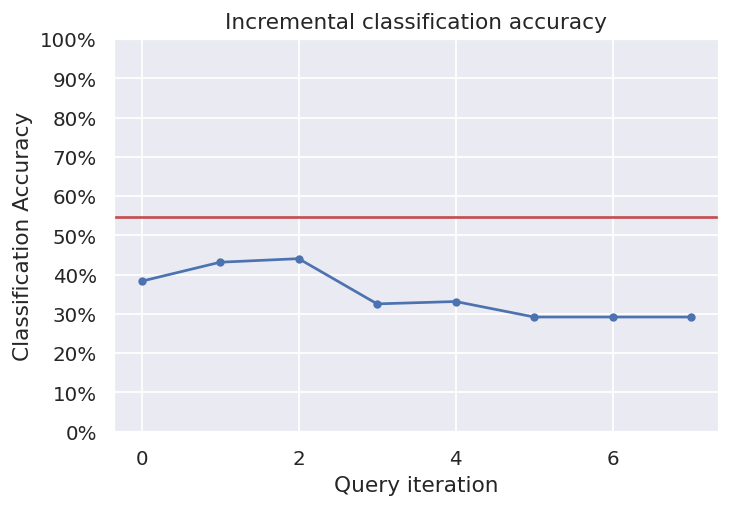

In [112]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=130)

ax.plot(performance_hist)
ax.scatter(range(len(performance_hist)), performance_hist, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
plt.axhline(y = 0.5477, color = 'r', linestyle = '-')
ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

In [ ]:
from functools import partial
from modAL.batch import uncertainty_batch_sampling
from modAL.uncertainty import margin_sampling, entropy_sampling

In [ ]:
learner = ActiveLearner( #use margin_sampling
  estimator=pipeline,

  X_training=X_initial,  y_training=y_initial,
  #query_strategy=preset_batch
  query_strategy=margin_sampling
)

Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6545       0.7000        0.6180  2.0987
      2        0.6078       0.7000        0.6273  2.0104
      3        0.3952       0.5000        0.8448  1.9922


In [ ]:
performance_hist=[]
for idx in range(n_queries):
  print('Query no. %d' % (idx + 1))
  query_idx, query_instance = learner.query(X_pool,n_instances=100) #
  learner.teach(
      X=X_pool[query_idx], y=y_pool[query_idx]
  )
    # remove queried instance from pool
  X_pool = np.delete(X_pool, query_idx, axis=0)
  y_pool = np.delete(y_pool, query_idx, axis=0)

  with torch.inference_mode():
    y_pred = pipeline.predict(X_test)
  performance_hist.append(accuracy_score(np.array(y_test),np.array(y_pred)))

Query no. 1
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6959       0.6000        0.6719  3.9812
      2        0.6092       0.4750        0.7010  4.0058
      3        0.4930       0.6250        0.9071  4.0168
Query no. 2
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6844       0.5833        0.7154  6.0526
      2        0.6881       0.5833        0.6907  6.0861
      3        0.5580       0.5667        0.7780  6.1108
Query no. 3
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6675       0.5875        0.6852  8.1750
      2        0.6510       0.6375        0.6758  8.2116
      3        0.5837       0.6375        0.6536  8.2524
Query no. 4
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6707       0.6000        0.6736  10.3429
      2        0.6211       0.5900        0.7380  10.5535
      3        0.3446       0.6200        1.2877  10.5792
Query no. 5
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6966       0.5667        0.6779  12.5560
      2        0.6658       0.6917        0.6500  12.5987
      3        0.5510       0.5750        0.7162  12.6268
Query no. 6
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6781       0.5857        0.6663  14.6701
      2        0.5805       0.6286        0.6291  14.6915
      3        0.3536       0.6000        0.8729  14.7002
Query no. 7
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6908       0.5687        0.6769  16.7679
      2        0.6665       0.6750        0.6248  16.8436
      3        0.5521       0.6500        0.7163  16.9333
Query no. 8
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6899       0.6278        0.6618  19.1030
      2        0.5891       0.6278        0.6651  19.5987
      3        0.3578       0.6167        0.8552  19.6251
Query no. 9
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6899       0.5650        0.6819  21.3947
      2        0.6677       0.6500        0.6313  21.5442
      3        0.5233       0.6100        0.7396  21.7161
Query no. 10
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6880       0.5727        0.6741  23.6604
      2        0.6163       0.6273        0.6479  23.7481
      3        0.4456       0.6318        0.6444  23.7785


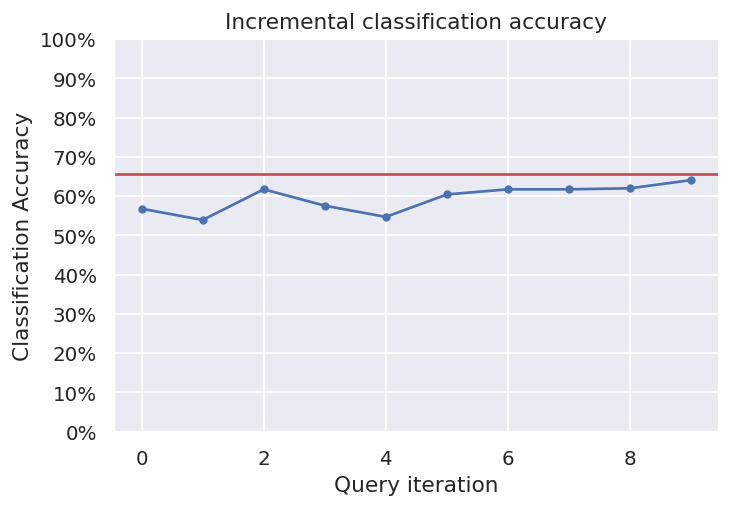

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=130)

ax.plot(performance_hist)
ax.scatter(range(len(performance_hist)), performance_hist, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
plt.axhline(y = 0.6563, color = 'r', linestyle = '-')
ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

In [ ]:
learner = ActiveLearner( #use margin_sampling
  estimator=pipeline,

  X_training=X_initial,  y_training=y_initial,
  #query_strategy=preset_batch
  query_strategy=entropy_sampling
)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6664       0.7000        0.6289  4.2459
      2        0.6006       0.7000        0.5941  1.8089
      3        0.4598       0.7000        0.6436  1.8264


In [ ]:
performance_hist=[]
n_queries=10
for idx in range(n_queries):
  print('Query no. %d' % (idx + 1))
  query_idx, query_instance = learner.query(X_pool,n_instances=100) #
  learner.teach(
      X=X_pool[query_idx], y=y_pool[query_idx]
  )
    # remove queried instance from pool
  X_pool = np.delete(X_pool, query_idx, axis=0)
  y_pool = np.delete(y_pool, query_idx, axis=0)

  with torch.inference_mode():
    y_pred = pipeline.predict(X_test)
  performance_hist.append(accuracy_score(np.array(y_test),np.array(y_pred)))

Query no. 1
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6958       0.5250        0.6865  3.7355
      2        0.6195       0.6250        0.6739  3.6900
      3        0.3238       0.5500        1.1795  3.6924
Query no. 2
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6920       0.5833        0.6817  5.6918
      2        0.5870       0.5667        0.7732  5.6747
      3        0.2684       0.6167        0.8861  5.7117
Query no. 3
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7064       0.5125        0.6922  7.8166
      2        0.6898       0.5500        0.6839  7.8394
      3        0.6144       0.6750        0.6086  7.9079
Query no. 4
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6970       0.7000        0.6808  9.7869
      2        0.6450       0.6700        0.6433  9.7146
      3        0.4538       0.6600        0.7716  9.6980
Query no. 5
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6915       0.5500        0.6861  11.7769
      2        0.6607       0.5500        0.7307  11.6826
      3        0.4298       0.6000        0.7304  11.8017
Query no. 6
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6872       0.5571        0.6885  13.6138
      2        0.6912       0.4357        0.6964  13.7249
      3        0.6597       0.6000        0.6304  13.6580
Query no. 7
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6835       0.6500        0.6432  15.5891
      2        0.5433       0.6438        0.6825  15.6098
      3        0.1644       0.5875        1.3192  15.6007
Query no. 8
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6817       0.5889        0.6697  17.5769
      2        0.5724       0.6778        0.6094  17.5463
      3        0.2556       0.6556        0.9606  17.5184
Query no. 9
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6840       0.6050        0.6439  19.4672
      2        0.5950       0.6450        0.6201  19.4884
      3        0.2830       0.6150        0.8895  19.5244
Query no. 10
Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6819       0.6227        0.6572  21.3857
      2        0.6164       0.6227        0.6398  21.4894
      3        0.4593       0.5455        0.9069  21.4547


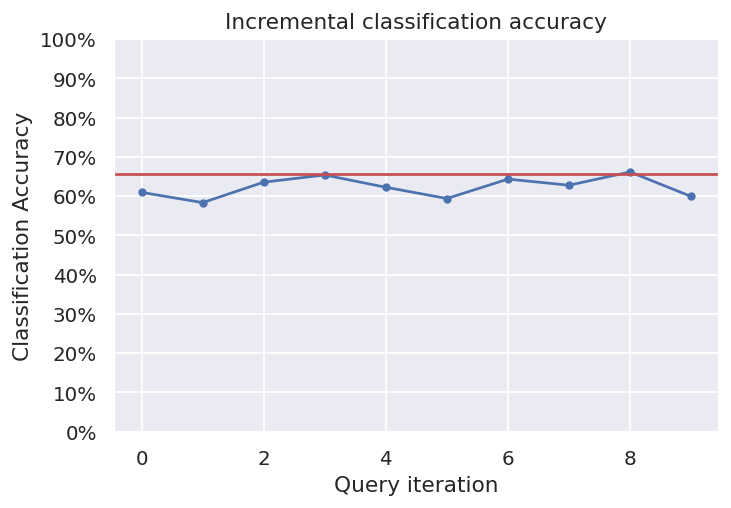

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=130)

ax.plot(performance_hist)
ax.scatter(range(len(performance_hist)), performance_hist, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
plt.axhline(y = 0.6563, color = 'r', linestyle = '-')
ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

In [ ]:
#interactive sampling

In [113]:
oracle='manual' #machine

In [116]:
!pip install Ipython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.9 MB/s eta 0:00:00


In [119]:
from IPython import display

In [123]:
accuracy_scores = [learner.score(X_test, y_test)]

for i in range(n_queries):
    display.clear_output(wait=True)
    query_idx, query_inst = learner.query(X_pool)
    # with plt.style.context('seaborn-white'):
    #     plt.figure(figsize=(10, 5))
    #     # plt.subplot(1, 2, 1)
    #     # plt.title('Digit to label')
    #     # plt.imshow(query_inst.reshape(8, 8))
    #     plt.subplot(1, 2, 1)
    #     plt.title('Accuracy of your model')
    #     plt.plot(range(i+1), accuracy_scores)
    #     plt.scatter(range(i+1), accuracy_scores)
    #     plt.xlabel('number of queries')
    #     plt.ylabel('accuracy')
    #     display.display(plt.gcf())
    #     plt.close('all')

    print("Which would be the label?")
    print(query_inst)
    y_new = np.array([int(input())], dtype=int)
    learner.teach(query_inst, y_new)
    X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
    accuracy_scores.append(learner.score(X_test, y_test))

Which would be the label?
['ළමයි ඉන්න මිනිස්සුන්ට රට හදන්න වෙලාවක් ඉතුරු වෙන්නෙ නැහැ. ඉන්දියාවේ මෝදිට ළමයිත් නැහැ ගෑණිත් අතෑරලා අවුරුදු 40 ක් වෙනව. සජියත් ගෑණි එලවගත්තොත් මෝදිගේ මල්ලි වෙන්න පුළුවන්.']
4


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NLPC-UOM--SinBERT-small/snapshots/f0eaaed69eaba28a4f98eaa31b92713c5c01e1db/config.json
Model config RobertaConfig {
  "_name_or_path": "NLPC-UOM/SinBERT-small",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 6,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 30000
}

loading file vocab.jso

Re-initializing module because the following parameters were re-set: name, num_labels.


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--NLPC-UOM--SinBERT-small/snapshots/f0eaaed69eaba28a4f98eaa31b92713c5c01e1db/config.json
Model config RobertaConfig {
  "_name_or_path": "NLPC-UOM/SinBERT-small",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 6,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_

Re-initializing criterion.
Re-initializing optimizer.


RuntimeError: ignored